# Exploratory data analysis (EDA)

Let's learn about the Saint Lucia households. We center our EDA around income and poverty.

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
savefig = True
savetab = False
if savefig:
    figsize=(3.5, 2.625)
else:
    figsize=(6,4)

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import mapclassify as mc
sns.set_theme(style="ticks")

In [2]:
# Load the data
household_survey = pd.read_csv('../data/processed/household_survey/Saint Lucia.csv')
household_survey['district'].replace({'AnseLaRayeCanaries' : 'Anse-La-Raye & Canaries'}, inplace=True)

## Socio-demographics

Let's first zoom into the basic socio-demographic attributes of the respondents. We are interested in the following by district:
1. Population;
2. Gender;
3. Age;
4. Household size.

The most populated district is Castries and the least populated district is Choiseul.

In [4]:
total_population = round(household_survey['popwgt'].sum())
district_population = household_survey.groupby('district')['popwgt'].sum().sort_values(ascending=False).round()

print('Saint Lucia population = ' + str('{:,}'.format(total_population)))
for district in district_population.index:
    print(district + ' = ' + str('{:,}'.format(round(district_population[district]))))

Saint Lucia population = 172,638
Castries = 70,959
Gros Islet = 27,467
Micoud = 17,436
Vieuxfort = 15,229
Dennery = 11,591
Soufriere = 8,985
Anse-La-Raye & Canaries = 8,667
Laborie = 6,828
Choiseul = 5,476


In [15]:
# Make a table of the population of each district in Saint Lucia.
tab = district_population.copy()
tab.index.name = 'District'
tab.name = 'Population'
tab = tab.astype(int)
tab = tab.to_frame()
if savetab:
    tab.style.to_latex(buf='../reports/tables/district_population.tex',
                       label='tab:district_population',
                       caption='Population of each @district in Saint Lucia.')

The following attribute is gender. Remarkably, the distribution of males vs females is not 50/50. The percentage of males is 14% higher than females.

In [16]:
gender = household_survey.groupby('sex').sum(numeric_only=True)['popwgt'] / total_population
print(f'Percentage of women in the survey: {round(gender.loc["female"] * 100)}%')
print(f'Percentage of men in the survey: {round(gender.loc["male"] * 100)}%')

Percentage of women in the survey: 43%
Percentage of men in the survey: 57%


Now let's examine what age groups. It is **important** to mention that there are no kids (<18) in this survey. However, the survey weights sum up to the total population of the country which is weird.

In [7]:
# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

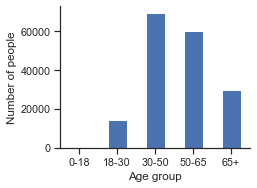

In [19]:
people_by_age = household_survey.groupby('age').sum(numeric_only=True)['popwgt']
age_bins = pd.cut(people_by_age.index, [0, 18, 30, 50, 65, 100])
people_by_age = people_by_age.groupby(age_bins).sum()
people_by_age.plot.bar(rot=0, figsize=(3.5, 2.625))
plt.xlabel('Age group')
plt.ylabel('Number of people')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_xticklabels(['0-18', '18-30', '30-50', '50-65', '65+'])
if savefig:
    plt.savefig('../reports/figures/eda/age_distribution.png', dpi=300, bbox_inches='tight')
    plt.savefig('../reports/figures/eda/age_distribution.pgf', bbox_inches='tight')

It seems that the predominant household size is 4 people with 23%, followed by 2 people household size with around 19%.

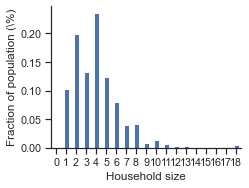

In [21]:
household_survey['hhsize_ae'] = household_survey['hhsize_ae'].astype(int)
household_size = household_survey.groupby('hhsize_ae')['popwgt'].sum() / total_population
hh_size = np.arange(0, household_size.index.max() + 1)
hh_size_values = household_size.reindex(hh_size, fill_value=0)
hh_size_values.plot.bar(rot=0, figsize=(3.5, 2.625))
plt.xlabel('Household size')
plt.ylabel('Fraction of population (\%)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);
# plt.gca().xaxis.set_major_locator(MultipleLocator(1))
if savefig:
    plt.savefig('../reports/figures/eda/household_size.pgf', bbox_inches='tight')
    plt.savefig('../reports/figures/eda/household_size.png', dpi=300, bbox_inches='tight')

In [22]:
country = 'Saint Lucia'
gdf = gpd.read_file(
    f'../data/raw/shapefiles/{country}/gadm36_LCA_shp/gadm36_LCA_1.shp')

# Align district names with the ones in the outcomes
gdf['NAME_1'].replace(
    {'Soufrière': 'Soufriere', 'Vieux Fort': 'Vieuxfort'}, inplace=True)

# Merge Anse-la-Raye and Canaries into a single geometry
geometry = gdf[gdf['NAME_1'].isin(
    ['Anse-la-Raye', 'Canaries'])].unary_union

# Add it to the dataframe
gdf.loc[len(gdf)] = [None, None, 'LCA.11_1', 'Anse-La-Raye & Canaries',
                        None, None, None, None, None, None, geometry]
gdf = gdf[gdf['NAME_1'].isin(household_survey['district'].unique())]
gdf = pd.merge(gdf, district_population.round(), left_on='NAME_1', right_index=True)
gdf.reset_index(inplace=True, drop=True)

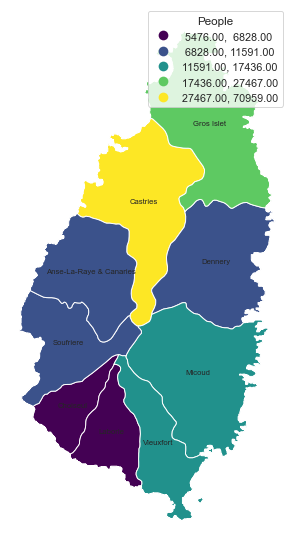

In [25]:
ax = gdf.plot(column='popwgt', scheme='fisher_jenks', figsize=(10,10), legend=True, legend_kwds={'title': 'People'})
for idx, row in gdf.iterrows():
        ax.annotate(text=row['NAME_1'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=8)
ax.axis('off');
if savefig:
        plt.savefig('../reports/figures/eda/pop_by_district.png', dpi=300, bbox_inches='tight')

In [27]:
# Load asset damage data
asset_damage = pd.read_excel('../data/processed/asset_damage/Saint Lucia.xlsx')
asset_damage['district'].replace({'AnseLaRayeCanaries' : 'Anse-La-Raye & Canaries'}, inplace=True)
gdf = pd.merge(gdf, asset_damage, left_on='NAME_1', right_on='district', how='left')
gdf['pml'] = gdf['pml'] / 1000000
gdf['pml'] = gdf['pml'].round(2)

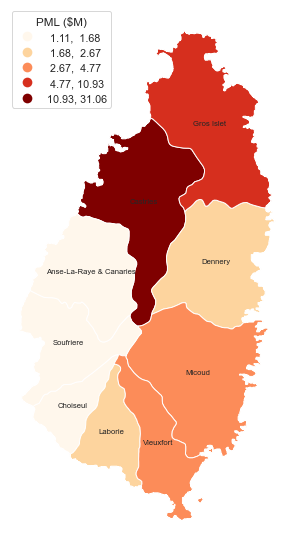

In [28]:
# Plot the distribution of the PMLs
ax = gdf.plot(column='pml', scheme='fisher_jenks', figsize=(10,10), cmap='OrRd', legend=True, legend_kwds={'title': 'PML ($M)', 'loc': 'upper left'})
for idx, row in gdf.iterrows():
        ax.annotate(text=row['NAME_1'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=8)
ax.axis('off')
if savefig:
        plt.savefig('../reports/figures//eda/pml_by_district.png', dpi=300, bbox_inches='tight')

## Poverty, income, expenditure and social benefits 

The simulation focuses on finding measures to mitigate the impact of a flood and prevent people from falling into poverty. Let's see at the poverty numbers before disaster strikes. Importantly, by poor here, we mean **poor in terms of expenditure** and not income.

The district that has the highest fraction of poor is **Dennery**. The next ones are Anse-La-Raye & Canaries and Vieuxfort. **Note that** Anse-La-Raye & Canaries has the lowest population among those three top regions (8,667 vs 11,591 for Dennery and 15,229 for Vieuxfort).

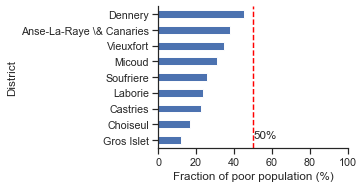

In [30]:
poor = household_survey[household_survey['is_poor'] == True]
poor_by_district = (poor.groupby('district')['popwgt'].sum().div(district_population) * 100).round(2).sort_values()
poor_by_district.index.name = 'District'
poor_by_district.name = 'Fraction of poor population (%)'
poor_by_district.rename({'Anse-La-Raye & Canaries' : 'Anse-La-Raye \& Canaries'}, inplace=True)
poor_by_district.plot.barh(figsize=(3.5, 2.625))
plt.xlabel('Fraction of poor population (%)')
plt.ylabel('District')
plt.xlim(0, 100)
plt.axvline(50, color='red', linestyle='--')
plt.text(50.5, 0, '50%', rotation=0, va='bottom')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
if savefig:
    plt.savefig('../reports/figures/eda/poor_by_district.png', bbox_inches='tight', dpi=300)
    plt.savefig('../reports/figures/eda/poor_by_district.pgf', bbox_inches='tight')

In [31]:
poor_by_district.sort_values(ascending=False)

District
Dennery                     45.00
Anse-La-Raye \& Canaries    37.98
Vieuxfort                   34.62
Micoud                      31.16
Soufriere                   25.55
Laborie                     23.41
Castries                    22.48
Choiseul                    16.85
Gros Islet                  11.82
Name: Fraction of poor population (%), dtype: float64

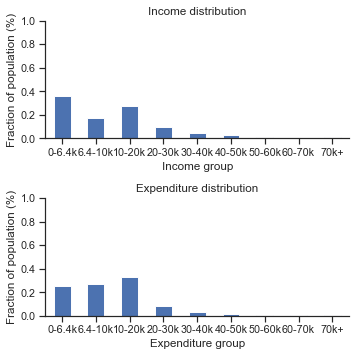

In [35]:
fig, ax = plt.subplots(figsize=(3.5*1.5, 2.625*2), nrows=2)
income = household_survey.copy()
income['aeinc'] = income['aeinc'].astype(float)
bins = [0, 6444, 10000, 20000, 30000, 40000, 50000, 60000, 70000, np.inf]
# 6443 is the poverty line (expenditure poverty line)
labels = ['0-6.4k', '6.4-10k', '10-20k', '20-30k', '30-40k', '40-50k', '50-60k', '60-70k', '70k+']
income['income_group'] = pd.cut(income['aeinc'], bins=bins, labels=labels)
income_grouped = income.groupby('income_group').sum(numeric_only=True)['popwgt'] / total_population
income_grouped.name = 'Income group'
income_grouped.name = 'Fraction of population (%)'
income_grouped.plot.bar(title='Income distribution', xlabel='Income group', ylabel='Fraction of population (%)', rot=0, ax=ax[0])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_ylim(0, 1)

expenditure = household_survey.copy()
expenditure['aeexp'] = expenditure['aeexp'].astype(float)
expenditure['expenditure_group'] = pd.cut(expenditure['aeexp'], bins=bins, labels=labels)
expenditure_grouped = expenditure.groupby('expenditure_group').sum(numeric_only=True)['popwgt'] / total_population
expenditure_grouped.index.name = 'Expenditure group'
expenditure_grouped.name = 'Fraction of population (%)'
expenditure_grouped.plot.bar(title='Expenditure distribution', xlabel='Expenditure group', ylabel='Fraction of population (%)', rot=0, ax=ax[1])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_ylim(0, 1)
fig.tight_layout()
if savefig:
    plt.savefig('../reports/figures/eda/income_expenditure_distribution.pgf', bbox_inches='tight')
    plt.savefig('../reports/figures/eda/income_expenditure_distribution.png', dpi=300, bbox_inches='tight')

In [ ]:
expenditure_grouped

Expenditure group
0-6.4k     0.250011
6.4-10k    0.265996
10-20k     0.328155
20-30k     0.083525
30-40k     0.030680
40-50k     0.015987
50-60k     0.009278
60-70k     0.006376
70k+       0.009629
Name: Fraction of population (%), dtype: float64

In [37]:
districts = household_survey['district'].unique()
districts.sort()

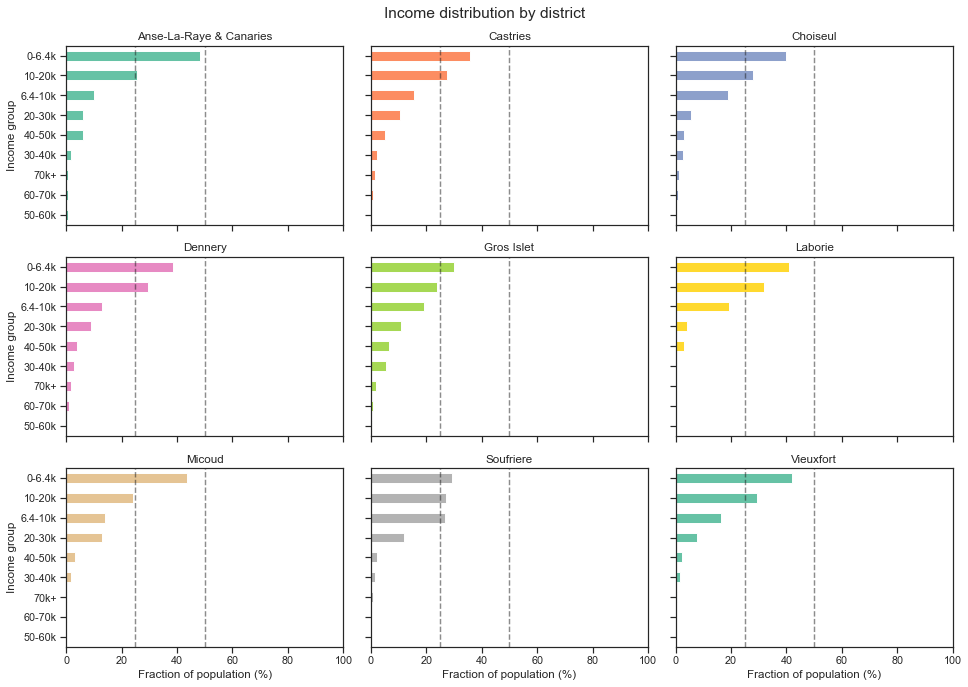

In [38]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,10), sharex=True, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(household_survey['district'].unique()))
d = {}
for i, district in enumerate(districts):
    district_population = household_survey[household_survey["district"] == district]['popwgt'].sum()
    district_income = income.groupby(["district", "income_group"]).sum(numeric_only=True)[['popwgt']].loc[district]
    district_income = round(district_income / district_population * 100, 2)
    district_income.index.name = 'Income group'
    district_income.columns = ['Fraction of population (%)']
    district_income.sort_values(by='Fraction of population (%)', ascending=True, inplace=True)
    district_income.plot(kind='barh', ax=ax[i//3, i%3], legend=False, title=district, rot=0, color=colors[i])
    d[district] = district_income.loc['0-6.4k']
    ax[i//3, i%3].set_xlim(0, 100)
    ax[i//3, i%3].set_xlabel('Fraction of population (%)')
    ax[i//3, i%3].axvline(x=25, color='k', linestyle='--', alpha=0.5)
    ax[i//3, i%3].axvline(x=50, color='k', linestyle='--', alpha=0.5)

fig.suptitle('Income distribution by district', fontsize=16)
fig.tight_layout()
if savefig:
    plt.savefig('../reports/figures/eda/income_distribution_by_district.png', dpi=300)

In [39]:
pd.DataFrame(d).T.sort_values(by='Fraction of population (%)')

,Fraction of population (%)
Gros Islet,23.99
Choiseul,27.84
Soufriere,29.13
Castries,35.90
Dennery,38.68
Laborie,40.89
Vieuxfort,41.84
Micoud,43.60
Anse-La-Raye & Canaries,48.28


In [40]:
districts = household_survey['district'].unique()
districts.sort()

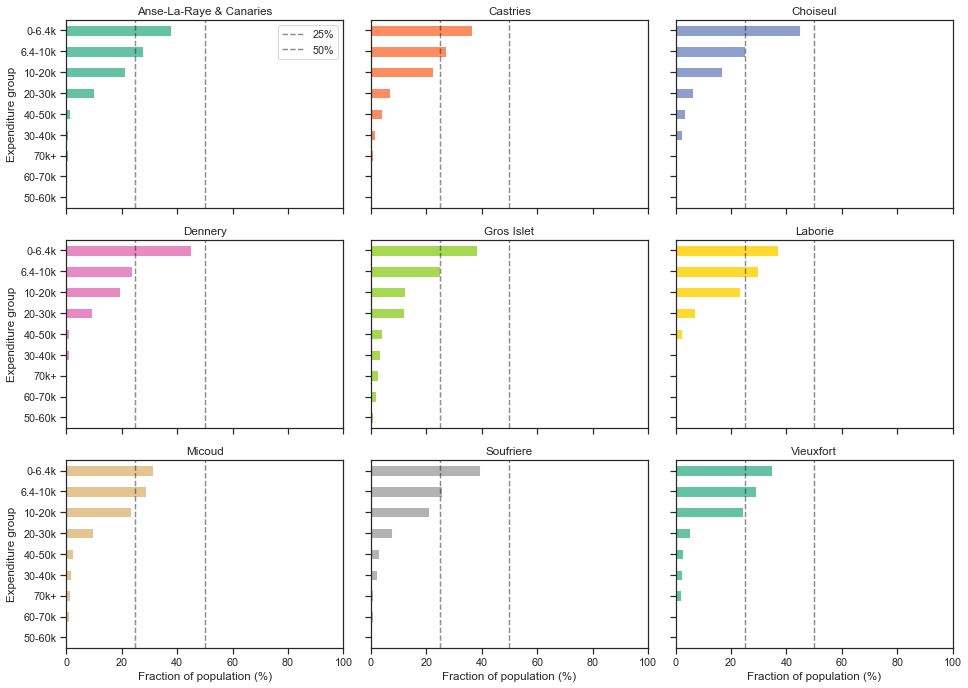

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,10), sharex=True, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(household_survey['district'].unique()))
d = {}
for i, district in enumerate(districts):
    district_population = household_survey[household_survey["district"] == district]['popwgt'].sum()
    district_income = expenditure.groupby(["district", "expenditure_group"]).sum(numeric_only=True)[['popwgt']].loc[district]
    district_income = round(district_income / district_population * 100, 2)
    district_income.index.name = 'Expenditure group'
    district_income.columns = ['Fraction of population (%)']
    district_income.sort_values(by='Fraction of population (%)', ascending=True, inplace=True)
    district_income.plot(kind='barh', ax=ax[i//3, i%3], legend=False, title=district, rot=0, color=colors[i])
    d[district] = district_income.loc['0-6.4k']
    ax[i//3, i%3].set_xlim(0, 100)
    ax[i//3, i%3].set_xlabel('Fraction of population (%)')
    ax[i//3, i%3].axvline(x=25, color='k', linestyle='--', alpha=0.5)
    ax[i//3, i%3].axvline(x=50, color='k', linestyle='--', alpha=0.5)
    # Add legend for vertical lines
    ax[0, 0].legend(['25%', '50%'])

# fig.suptitle('Expenditure distribution by district', fontsize=16)
fig.tight_layout()
if savefig:
    fig.savefig('../reports/figures/eda/consumption_distribution_by_district.png', dpi=300)

In [42]:
pd.DataFrame(d).T.sort_values(by='Fraction of population (%)')

,Fraction of population (%)
Gros Islet,11.82
Choiseul,16.85
Castries,22.39
Laborie,23.41
Soufriere,25.55
Micoud,31.16
Vieuxfort,34.62
Anse-La-Raye & Canaries,37.98
Dennery,45.01


In [43]:
benefits = household_survey['aesoc'].copy()
benefits = benefits.astype('float')
benefits.name = 'Social benefits'
benefits.describe()

count    1493.000000
mean       26.772398
std       213.759362
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3360.000000
Name: Social benefits, dtype: float64